In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, expon, norm

In [2]:
class Data_generator:
    def __init__(self, _alpha_r=0, _beta_r=1, _d=1, _alpha_u=0, _beta_u=1, _gamma=1, _theta=0, __lambda=1):
        self.alpha_r = _alpha_r
        self.beta_r = _beta_r
        self.d = _d
        self.alpha_u = _alpha_u
        self.beta_u = _beta_u
        self.gamma = _gamma
        self.theta = _theta
        self._lambda = __lambda

    def gen_data(self, n=1000, T=100):
        r=np.zeros((T,n)) #r yield
        eps=np.zeros(n)
        u=np.zeros(n)
        for i in range(T):
            u = self.alpha_u+self.beta_u*u+self.gamma*eps**2+self.theta*np.where(eps<0,eps**2,0)+np.random.normal(scale=1/self._lambda,size=n)
            eps=np.random.standard_t(df=self.d, size=n)*np.sqrt(u)
            r[i]=self.alpha_r+self.beta_r*u+eps
        return r
    
    def gen_data_full(self, n=1000, T=100):
        r=np.zeros((T,n)) #r yield
        eps_list=np.zeros((T,n))
        u_list=np.zeros((T,n))
        u=np.zeros(n)
        eps=np.zeros(n)
        r[0]=self.alpha_r
        for i in range(T):
            u = self.alpha_u+self.beta_u*u+self.gamma*eps**2+self.theta*np.where(eps<0,eps**2,0)+np.random.exponential(scale=1/self._lambda,size=n)
            eps=np.random.standard_t(df=self.d, size=n)*np.sqrt(u)
            u_list[i]=u
            eps_list[i]=eps
            r[i]=self.alpha_r+self.beta_r*u+eps
        return r, u_list, eps_list
    
    
    
#DG = Data_generator(0.2, 0.2, 6.0, 0.6, 0.4, 0.1, 0.02, 2.5)
#print(DG.gen_data_full(5, 5))    
#Test texts

In [281]:
params = (0,0.5,6,0.5,0.2,0,0,4)

In [282]:
T = 100
#DG = Data_generator(*params)
#data = DG.gen_data_full(10000, T)
#np.save("data_"+str(params)+".npy", data)

In [283]:
with open("data_"+str(params)+".npy", "rb") as f:
    data = np.load(f)

In [284]:
class TEST_SAMPLER:
    """test sampler"""
    ESS_list = []
    sample_num = 1
    def __init__(self, T, params):
        self.alpha_r, self.beta_r, self.d, self.alpha_u, self.beta_u,self.gamma, self.theta, self._lambda = params
        self.params = params
        self.T = T 

    def log_likelihood_update(self,epsilon,r,epsilon_past,r_past):
        ''' Compute log joint likelihood of l=log p(eps_t,r_t|eps_{t-1},r_{t-1})'''
        #Input:  epsilon  (n,) epsilon_past  (n,)  r (1,) r_past (1,)
        #Output: log_prob (n,)

        prior=0 #do we need prior on r_0, eps_0?

        ''' Calculate u, w, nu and eta'''
        #u=(r-epsilon-self.alpha_r)/self.beta_r
        u_past= (r_past-epsilon_past-self.alpha_r)/self.beta_r

        w=self.alpha_u+self.beta_u*u_past+(self.gamma+self.theta*(epsilon_past<0))*(epsilon_past**2)

        nu=np.sqrt(self.beta_r/(r-epsilon-self.alpha_r))*epsilon
        eta=(r-epsilon-self.alpha_r)/self.beta_r-w
        #eta=np.maximum(eta,1e-7)
        #print(f"eps:{epsilon[:10]}\n eps_past:{epsilon_past[:10]}\n r:{r} r_past:{r_past} etamin:{eta.min()}\n w:{w[:10]}, nu:{nu[:10]}\n eta:{eta[:10]}\n")
        #print(eta.min())
        #eta=(eta>=0)*eta+(eta<=0)*1e-7
        #assert eta.min()>=0 #eta should follow exponential distribution

        logp_exp=norm.logpdf(eta, scale=1/self._lambda)
        logp_t=t.logpdf(nu,self.d)


        log_joint=logp_exp+logp_t -0.5*(np.log(self.beta_r)+np.log(r-epsilon-self.alpha_r))+prior
        #print(log_joint)
        return log_joint
        
    def sample(self, sample_num:int, r, exp_scale=1, resample_thre=0.2, seed=0):
        self.ESS_list = []
        self.sample_num = sample_num
        np.random.seed(seed)
        
        samples = np.zeros((sample_num,self.T))
        weights_full = np.zeros((sample_num,self.T))
        log_weights = np.ones(sample_num)
        eps=np.zeros(sample_num)
        r_past=self.alpha_r
        for i in range(self.T): 
            rr=r[i]
            eps_past=eps.copy()
            u_past= (r_past-eps_past-self.alpha_r)/self.beta_r
            w=self.alpha_u+self.beta_u*u_past+(self.gamma+self.theta*(eps_past<0))*(eps_past**2)
            if type(exp_scale)==list:
                temp_exp_scale = exp_scale[i]
            else: 
                temp_exp_scale = exp_scale
            eps = self.policy(eps_past, rr, w, temp_exp_scale)
            log_weights += self.log_likelihood_update(eps,rr,eps_past,r_past)-self.log_policy_density(eps, rr, w, temp_exp_scale)
            r_past=rr
            samples[:,i]=eps
            weights=np.exp(log_weights)
            weights=weights/weights.sum()
            
            ESS = 1/np.sum(np.power(weights, 2))
            self.ESS_list.append(ESS)
            if ESS < resample_thre*sample_num:
                samples[:,i] = self.resample(samples[:,i], weights)
                weights = np.ones(sample_num)/sample_num
                log_weights=np.zeros(sample_num)
            weights_full[:, i] = weights
        return samples, weights, weights_full
    
    def plot_ESS(self, y_high=0, title=""):
        if y_high == 0:
            y_high = self.sample_num
        plt.plot(range(self.T), self.ESS_list)
        plt.ylim(0, y_high)
        plt.xlim(0, self.T)
        plt.ylabel("ESS")
        if title != "":
            plt.title(title)
        plt.show()
        plt.clf()
    
    def resample(self, samples, weights):
        index = np.random.choice(list(range(len(weights))), p=weights, size=(len(weights)))
        return samples[index]
    
    def policy(self, eps_past, rr, w, exp_scale):
        #return rr-self.alpha_r-np.random.exponential(scale=exp_scale,size=self.sample_num) #a simple policy
        #return rr-self.alpha_r-(np.random.rand(self.sample_num)*0.8)**2
        return rr-self.alpha_r-np.abs(np.random.normal(scale=exp_scale,size=self.sample_num)) #a simple policy
    
    def log_policy_density(self, eps, rr, w, exp_scale):
        #return expon.logpdf(rr-self.alpha_r-eps, scale=exp_scale)
        #return np.log(0.8-(rr-self.alpha_r-eps))
        return norm.logpdf(rr-self.alpha_r-eps, scale=exp_scale)

In [285]:
sampler = TEST_SAMPLER(T, params)

In [288]:
class LOGLIKELIHOOD:
        def __init__(self, params):
                self.alpha_r, self.beta_r, self.d, self.alpha_u, self.beta_u,self.gamma, self.theta, self._lambda = params
                self.params = params

        def log_likelihood_update(self,epsilon,r,epsilon_past,r_past):
                ''' Compute log joint likelihood of l=log p(eps_t,r_t|eps_{t-1},r_{t-1})'''
                #Input:  epsilon  (n,) epsilon_past  (n,)  r (1,) r_past (1,)
                #Output: log_prob (n,)

                prior=0 #do we need prior on r_0, eps_0?

                ''' Calculate u, w, nu and eta'''
                u_past= (r_past-epsilon_past-self.alpha_r)/self.beta_r

                w=self.alpha_u+self.beta_u*u_past+(self.gamma+self.theta*(epsilon_past<0))*(epsilon_past**2)

                nu=np.sqrt(self.beta_r/(r-epsilon-self.alpha_r))*epsilon
                eta=(r-epsilon-self.alpha_r)/self.beta_r-w

                logp_exp=norm.logpdf(eta, scale=1/self._lambda)
                logp_t=t.logpdf(nu,self.d)

                log_joint=logp_exp+logp_t -0.5*(np.log(self.beta_r)+np.log(r-epsilon-self.alpha_r))+prior
                #print(log_joint)
                return log_joint
        
        def compute_upper(self, r, eps_past,r_past):
                return r-self.alpha_r
        
        def change_form(self, eps,r,eps_past,r_past):
                return r-self.alpha_r-eps

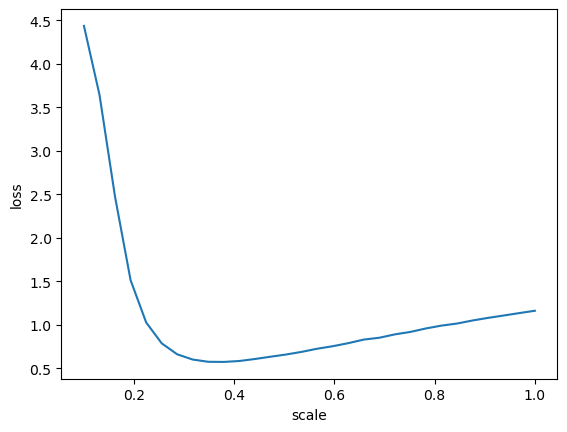

In [339]:
'''first policy scale is fixed to s'''
'''policy is np.abs(np.normal(scale=s))'''
np.random.seed(0)
N = 1000
x_list = np.linspace(0.1, 1, 30)
y_list = []
y_list_2 = []
for s in list(x_list):
        '''compute the avg loss'''
        loss = 0
        for i in range(1, T):
                LL = LOGLIKELIHOOD(params)
                '''get r, r_past, eps_past at time stamp i'''
                r = data[0][i, 0]
                r_past = data[0][i-1, 0]
                eps_past = r_past-np.abs(np.random.normal(scale=0.15, size=N)+0.4)
                '''test policy with scale s'''
                ub = LL.compute_upper(r, eps_past, r_past)
                eps = ub - np.abs(np.random.normal(scale=s, size=N))
                '''compute loss'''
                weights = LL.log_likelihood_update(eps, r, eps_past, r_past) - norm.logpdf(ub-eps, scale=s)
                weights = np.exp(weights)
                weights /= np.sum(weights)
                loss += np.log(N*np.sum(weights**2))
        loss /= T-1
        y_list.append(loss)
'''plot loss curve at dif s'''
plt.plot(x_list, y_list)
plt.xlabel("scale")
plt.ylabel("loss")
plt.show()

In [340]:
samples, weights, weights_full = sampler.sample(10000, data[0][:,0], exp_scale=0.4, resample_thre=0.1)

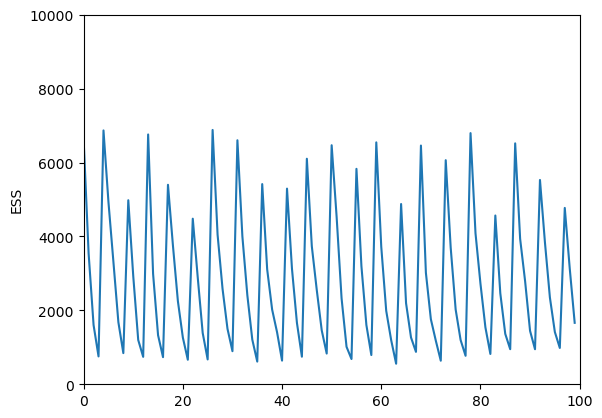

<Figure size 640x480 with 0 Axes>

In [341]:
sampler.plot_ESS()

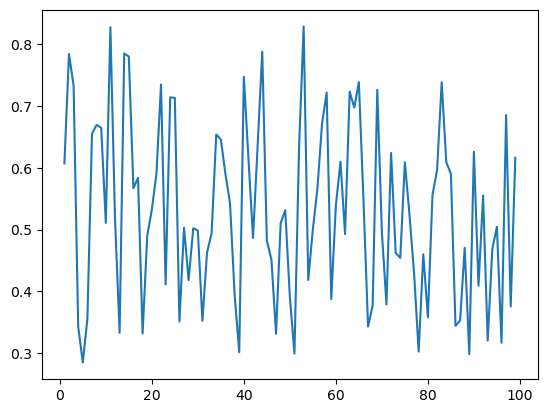

In [353]:
'''second policy dif scale at each time stamp'''
samples, weights, weights_full = sampler.sample(10000, data[0][:,0], exp_scale=0.4, resample_thre=0.1)
np.random.seed(0)
N = 10000
x_list = np.linspace(0.1, 0.6, 30)
scale_list = [0.4]
loss_list = [np.nan]
for i in range(1, T):
        loss = 100
        best_s = 0
        LL = LOGLIKELIHOOD(params)
        '''get r r_past, eps_past at time stamp i'''
        '''eps_past is based on previous sampling results of posterior'''
        r = data[0][i, 0]
        r_past = data[0][i-1, 0]
        index = np.random.choice(list(range(weights_full.shape[0])), p=weights_full[:,i-1], size=(N))
        eps_past = (samples[:,i-1])[index]

        for s in list(x_list):
                '''sample eps using policy'''
                ub = LL.compute_upper(r, eps_past, r_past)
                eps = ub - np.abs(np.random.normal(scale=s, size=N))
                '''compute loss'''
                weights = LL.log_likelihood_update(eps, r, eps_past, r_past) - norm.logpdf(ub-eps, scale=s)
                weights = np.exp(weights)
                weights /= np.sum(weights)
                temp_loss = np.log(N*np.sum(weights**2))
                '''find best policy'''
                if loss > temp_loss: 
                        loss = temp_loss
                        best_s = s
        '''scale list'''
        scale_list.append(best_s)
        loss_list.append(loss)
plt.plot(range(T), loss_list)
plt.show()

In [354]:
samples, weights, weights_full = sampler.sample(10000, data[0][:,0], exp_scale=scale_list, resample_thre=0.1)

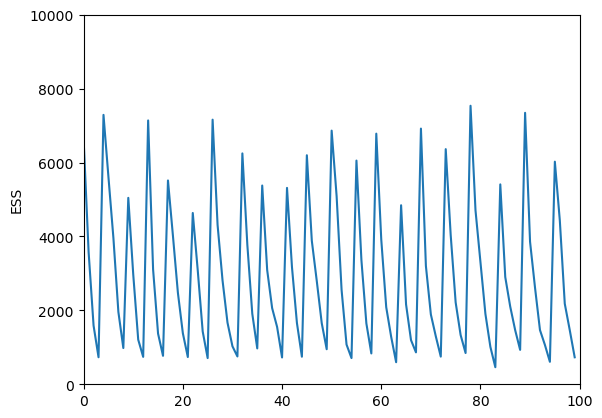

<Figure size 640x480 with 0 Axes>

In [355]:
sampler.plot_ESS()

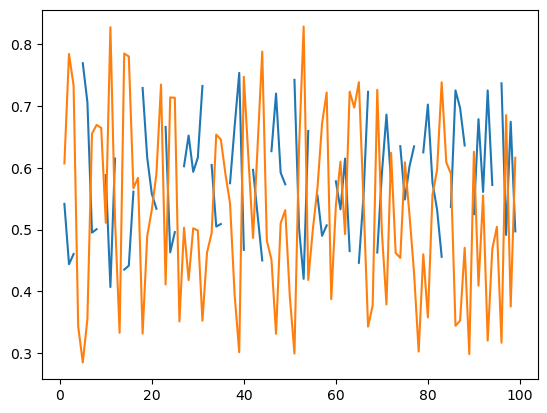

In [358]:
temp_list = sampler.ESS_list
temp = [np.nan]
for i in range(1, T):
    if temp_list[i-1]>temp_list[i]:
        temp.append(temp_list[i]/temp_list[i-1])
    else: 
        temp.append(np.nan)
plt.plot(range(T), temp)
plt.plot(range(T), loss_list)
plt.show()

-1.3472932465254581


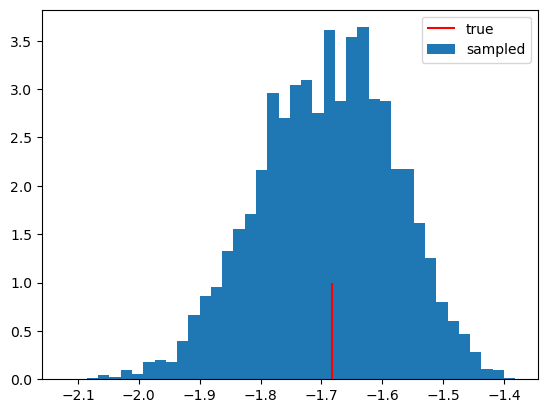

In [345]:
i = 75
index = np.random.choice(list(range(len(weights))), p=weights_full[:,i], size=(len(weights)))
print(data[0][i, 0])
plt.vlines(data[2][i,0], ymin=0, ymax=1, color='r', label='true')
plt.hist((samples[:,i])[index], density=True, bins=40, label="sampled")
plt.legend()
plt.show()